# 13.8. 区域卷积神经网络（R-CNN）系列

除了 13.7节中描述的单发多框检测之外， 区域卷积神经网络（region-based CNN或regions with CNN features，R-CNN） (Girshick et al., 2014)也是将深度模型应用于目标检测的开创性工作之一。 本节将介绍R-CNN及其一系列改进方法：快速的R-CNN（Fast R-CNN） (Girshick, 2015)、更快的R-CNN（Faster R-CNN） (Ren et al., 2015)和掩码R-CNN（Mask R-CNN） (He et al., 2017)。 限于篇幅，我们只着重介绍这些模型的设计思路。

## 13.8.1. R-CNN
R-CNN首先从输入图像中选取若干（例如2000个）提议区域（如锚框也是一种选取方法），并标注它们的类别和边界框（如偏移量）。 (Girshick et al., 2014)然后，用卷积神经网络对每个提议区域进行前向传播以抽取其特征。 接下来，我们用每个提议区域的特征来预测类别和边界框。

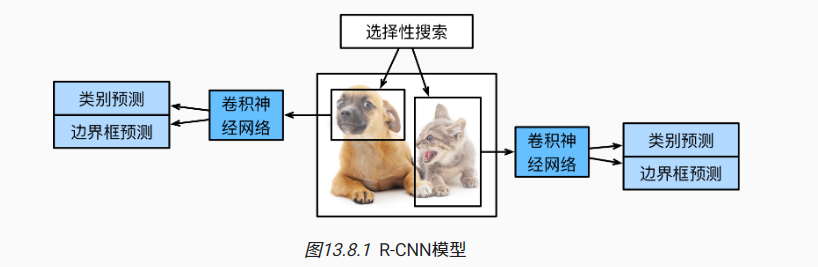

图13.8.1展示了R-CNN模型。具体来说，R-CNN包括以下四个步骤：
1. 对输入图像使用选择性搜索来选取多个高质量的提议区域 (Uijlings et al., 2013)。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域都将被标注类别和真实边界框；
2. 选择一个预训练的卷积神经网络，并将其在输出层之前截断。将每个提议区域变形为网络需要的输入尺寸，并通过前向传播输出抽取的提议区域特征；
3. 将每个提议区域的特征连同其标注的类别作为一个样本。训练多个支持向量机对目标分类，其中每个支持向量机用来判断样本是否属于某一个类别；
4. 将每个提议区域的特征连同其标注的边界框作为一个样本，训练线性回归模型来预测真实边界框。

尽管R-CNN模型通过预训练的卷积神经网络有效地抽取了图像特征，但它的速度很慢。 想象一下，我们可能从一张图像中选出上千个提议区域，这需要上千次的卷积神经网络的前向传播来执行目标检测。 这种庞大的计算量使得R-CNN在现实世界中难以被广泛应用。

## 13.8.2. Fast R-CNN
R-CNN的主要性能瓶颈在于，对每个提议区域，卷积神经网络的前向传播是独立的，而没有共享计算。 由于这些区域通常有重叠，独立的特征抽取会导致重复的计算。 Fast R-CNN (Girshick, 2015)对R-CNN的主要改进之一，是仅在整张图象上执行卷积神经网络的前向传播。

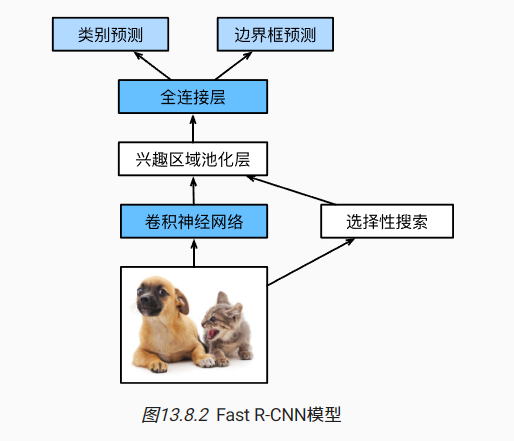